# ODM2REST API DEMO

This notebook was created by Landung Setiawan to show the use of ODM2RESTAPI hosted at http://54.186.36.247:8001/v1/docs/

## Import Modules

In [1]:
# Import libaries for explorations
%matplotlib inline
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
import json
import dateutil.tz
import pytz
from urllib.parse import urljoin 

import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def odm2rest_request(endpoint, qparams=None):
    api_version = 'v1'
    base_url = 'http://54.186.36.247:8001'
    root_url = urljoin(base_url, api_version) + '/'
    
    req_url = urljoin(root_url, endpoint)
    req = requests.get(req_url, params=qparams)
    
    if req.status_code == 200 and req.json():
        return req.json()
    else:
        print('There are no data.')

In [3]:
def get_odm2rest_resultvalues_df(var_code, export_df=False):
    print(var_code)
    res_params = {
        'variableID': odm2rest_request('variables', {'variableCode': var_code})[0]['VariableID']
    }
    
    results = odm2rest_request('results', res_params)
    
    ls = pd.to_datetime([obs['ResultDateTime'] for obs in results])
    print('Start Date: {0} | End Date: {1}'.format(ls.min().isoformat(), ls.max().isoformat()))
    
    if export_df:
        rv_rec = []
        for r in results:
            rv_params = {
                'resultID': r['ResultID']
            }
            dt = odm2rest_request('resultvalues', rv_params)[0]
            vdt_local = pd.to_datetime(dt['valuedatetime']).tz_localize(dateutil.tz.tzoffset(None, int(dt['valuedatetimeutcoffset'])*60*60))
            rv = {'ValueDateTime': vdt_local,
                  'DataValue': dt['datavalue'],
                  'UnitsTypeCV': r['Unit']['UnitsTypeCV'],
                  'UnitsAbbrev': r['Unit']['UnitsAbbreviation'],
                  'ValueDateTimeUTC': vdt_local.astimezone(pytz.UTC)
                 }
            rv_rec.append(rv)

        return pd.DataFrame.from_records(rv_rec)

---

## 1. Looking at where samples are collected.

In [4]:
sf_params = {
    'samplingFeatureType': 'Site'
}

In [5]:
%time sf_json = odm2rest_request('samplingfeatures', sf_params)

CPU times: user 9.27 ms, sys: 4 ms, total: 13.3 ms
Wall time: 3.39 s


In [6]:
df = pd.DataFrame.from_records(sf_json)

In [7]:
print('There are {} Sites'.format(len(df.index)))

There are 67 Sites


In [8]:
# Create a GeoPandas GeoDataFrame from Sites DataFrame
ptgeom = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
sites = gpd.GeoDataFrame(df, geometry=ptgeom, crs={'init': 'epsg:4326'})
sites.head(5)

,ElevationDatumCV,Elevation_m,FeatureGeometryWKT,Latitude,Longitude,SamplingFeatureCode,SamplingFeatureDescription,SamplingFeatureGeotypeCV,SamplingFeatureID,SamplingFeatureName,SamplingFeatureTypeCV,SamplingFeatureUUID,SiteTypeCV,SpatialReferenceID,geometry
0,EGM96,1356.0,None,40.745078,-111.854449,RB_1300E,None,Point,1,Red Butte Creek at 1300E (downstream of spring),Site,0dde8ef6-ec2f-42c0-ab50-20c6c02e89b2,Stream,4,POINT (-111.854449 40.745078)
1,EGM96,1356.0,None,40.745106,-111.854389,RB_1300ESpring,None,Point,2,Spring that enters Red Butte Creek at 1300E,Site,9848bbfe-ea3f-4918-a324-13e8ede5381c,Spring,4,POINT (-111.854389 40.745106)
2,EGM96,1289.0,None,40.741583,-111.917667,RB_900W_BA,None,Point,3,Red Butte Creek terminus at Jordan River at 13...,Site,688017bc-9e02-4444-a21d-270366be2348,Stream,4,POINT (-111.917667 40.741583)
3,EGM96,1519.0,None,40.766134,-111.826530,RB_Amphitheater,None,Point,4,Red Butte Creek below Red Butte Garden Amphith...,Site,9cfe685b-5cda-4e38-98d9-406d645c7d21,Stream,4,POINT (-111.82653 40.766134)
4,EGM96,1648.0,None,40.779602,-111.806669,RB_ARBR_AA,None,Point,5,Red Butte Creek above Red Butte Reservoir Adan...,Site,98c7f63a-fdfb-4898-87c6-5aa8ec34d1e4,Stream,4,POINT (-111.806669 40.779602)


### Create Folium Basemap

In [9]:
c = sites.unary_union.centroid # GeoPandas heavy lifting
m = folium.Map(location=[c.y, c.x], tiles='CartoDB positron', zoom_start=8)

### Plot sites onto map

In [10]:
marker_cluster = MarkerCluster().add_to(m)
for idx, feature in sites.iterrows():
    folium.Marker(location=[feature.geometry.y, feature.geometry.x], 
                  icon=folium.Icon(color='green'),
                  popup="{0} ({1}): {2}".format(
                      feature['SamplingFeatureCode'], feature['SiteTypeCV'], feature['SamplingFeatureName'])
                 ).add_to(marker_cluster)
m

Now that we have a map, we can see where all the sites are exactly!

---
## 2. All possible variables collected

In [11]:
var = odm2rest_request('variables')

In [12]:
variables = pd.DataFrame.from_records(var)

In [13]:
variables

,NoDataValue,SpeciationCV,VariableCode,VariableDefinition,VariableID,VariableNameCV,VariableTypeCV
0,-9999.0,N,TN,,1,"Nitrogen, total",Water quality
1,-9999.0,P,TP,,2,"Phosphorus, total",Water quality
2,-9999.0,N,Nitrate,,3,"Nitrogen, dissolved nitrite (NO2) + nitrate (NO3)",Water quality
3,-9999.0,N,Ammonia,,4,"Nitrogen, NH4",Water quality
4,-9999.0,P,Phosphate,,5,"Phosphorus, orthophosphate dissolved",Water quality
5,-9999.0,Not Applicable,Tcoliform,,6,"Coliform, total",Water quality
6,-9999.0,Not Applicable,E-coli,,7,E-coli,Water quality
7,-9999.0,C,DOC,,8,"Carbon, dissolved organic",Water quality
8,-9999.0,N,TDN,,9,"Nitrogen, total dissolved",Water quality
9,-9999.0,Not Applicable,Abs254,,10,Absorbance,Water quality


---
## 3. Request results for VariableCode `Nitrate` (Nitrogen, dissolved nitrite (NO2) + nitrate (NO3))

In [14]:
varcode = 'Nitrate'

In [15]:
res_params = {
    'variableID': odm2rest_request('variables', {'variableCode': varcode})[0]['VariableID']
}

In [16]:
%time results = odm2rest_request('results', res_params)

CPU times: user 48.7 ms, sys: 12.7 ms, total: 61.4 ms
Wall time: 8.45 s


In [17]:
print('Number of results for {0}: {1}'.format(varcode, len(results)))

Number of results for Nitrate: 488


In [18]:
# ResultDateTime range (min & max)
ls = pd.to_datetime([obs['ResultDateTime'] for obs in results])
print('Start Date: {0} | End Date: {1}'.format(ls.min().isoformat(), ls.max().isoformat()))

Start Date: 2014-06-30T00:00:00 | End Date: 2016-01-14T13:00:00


In [19]:
# Dig into one
result = results[0]
result.keys()

dict_keys(['ResultID', 'ResultUUID', 'FeatureActionID', 'ResultTypeCV', 'VariableID', 'UnitsID', 'TaxonomicClassifierID', 'ProcessingLevelID', 'ResultDateTime', 'ResultDateTimeUTCOffset', 'ValidDateTime', 'ValidDateTimeUTCOffset', 'StatusCV', 'SampledMediumCV', 'ValueCount', 'FeatureAction', 'ProcessingLevel', 'TaxonomicClassifier', 'Unit', 'Variable'])

There are a rich of information about each result!

In [20]:
result

{'FeatureAction': {'Action': {'ActionDescription': None,
   'ActionFileLink': None,
   'ActionID': 10003,
   'ActionTypeCV': 'Specimen analysis',
   'BeginDateTime': '2015-01-04T00:00:00',
   'BeginDateTimeUTCOffset': -7,
   'EndDateTime': None,
   'EndDateTimeUTCOffset': None,
   'Method': {'MethodCode': 'Ast_EPA353.2',
    'MethodDescription': 'Nitrate-Nitrite (Colorimetric, Automated, Cadmium Reduction), MDL 0.005 mg/l',
    'MethodID': 11,
    'MethodLink': '',
    'MethodName': 'Astoria EPA 353.2',
    'MethodTypeCV': 'Specimen analysis',
    'Organization': {'OrganizationCode': 'USUABL',
     'OrganizationDescription': '',
     'OrganizationID': 6,
     'OrganizationLink': 'http://www.usu.edu',
     'OrganizationName': 'USU Aquatic Biogeochemistry Lab',
     'OrganizationTypeCV': 'Research organization',
     'ParentOrganizationID': None},
    'OrganizationID': 6},
   'MethodID': 11},
  'ActionID': 10003,
  'FeatureActionID': 10003,
  'SamplingFeature': {'ElevationDatumCV': 'Unkn

---
## Request result values for each observation (by result uuid), then import into Pandas DataFrame

In [21]:
resultids = [str(r['ResultID']) for r in results]

In [22]:
rv_params = {
    'resultID': ','.join(resultids)
}

In [23]:
%time resultvalue_records = odm2rest_request('resultvalues', rv_params)

CPU times: user 8.54 ms, sys: 2.25 ms, total: 10.8 ms
Wall time: 376 ms


In [24]:
resultvalue_df = pd.DataFrame.from_records(resultvalue_records)

In [25]:
resultvalue_df.head()

,datavalue,resultid,valuedatetime,valuedatetimeutcoffset,valueid
0,0.0100,4,2014-12-11T11:16:48,-7,4
1,3.0874,16,2014-12-02T09:36:00,-7,16
2,0.2577,19,2015-09-29T11:45:36,-6,19
3,0.0577,22,2014-09-16T10:04:48,-6,22
4,0.1177,25,2014-09-01T13:26:24,-6,25


In [26]:
resultvalue_df['valuedtoff'] = resultvalue_df.apply(lambda x: pd.to_datetime(x['valuedatetime']).tz_localize(dateutil.tz.tzoffset(None, 
                                                                                                                               int(x['valuedatetimeutcoffset'])*60*60)).astimezone(pytz.UTC), axis=1)

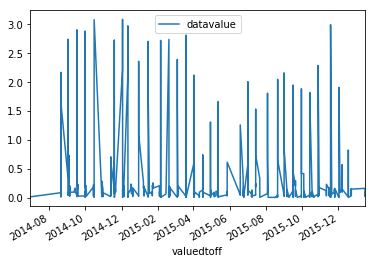

In [27]:
resultvalue_df.plot(y='datavalue', x='valuedtoff')

---
## 4. Comparing variables `Nitrate` (Nitrogen, dissolved nitrite (NO2) + nitrate (NO3)) vs `Phosphate` (Phosphorus, orthophosphate dissolved)

In [28]:
# Check the dates for each data
df1 = get_odm2rest_resultvalues_df('Nitrate', export_df=True)

Nitrate
Start Date: 2014-06-30T00:00:00 | End Date: 2016-01-14T13:00:00


In [29]:
df2 = get_odm2rest_resultvalues_df('Phosphate', export_df=True)

Phosphate
Start Date: 2014-06-30T00:00:00 | End Date: 2016-01-14T13:00:00


In [30]:
df1.head()

,DataValue,UnitsAbbrev,UnitsTypeCV,ValueDateTime,ValueDateTimeUTC
0,0.0100,mg/l,Concentration or density mass per volume,2014-12-11 11:16:48-07:00,2014-12-11 18:16:48+00:00
1,3.0874,mg/l,Concentration or density mass per volume,2014-12-02 09:36:00-07:00,2014-12-02 16:36:00+00:00
2,0.2577,mg/l,Concentration or density mass per volume,2015-09-29 11:45:36-06:00,2015-09-29 17:45:36+00:00
3,0.0577,mg/l,Concentration or density mass per volume,2014-09-16 10:04:48-06:00,2014-09-16 16:04:48+00:00
4,0.1177,mg/l,Concentration or density mass per volume,2014-09-01 13:26:24-06:00,2014-09-01 19:26:24+00:00


In [33]:
df2.head()

,DataValue,UnitsAbbrev,UnitsTypeCV,ValueDateTime,ValueDateTimeUTC
0,0.0156,mg/l,Concentration or density mass per volume,2014-12-11 11:16:48-07:00,2014-12-11 18:16:48+00:00
1,0.0100,mg/l,Concentration or density mass per volume,2014-12-02 09:36:00-07:00,2014-12-02 16:36:00+00:00
2,0.0100,mg/l,Concentration or density mass per volume,2015-09-29 11:45:36-06:00,2015-09-29 17:45:36+00:00
3,0.0100,mg/l,Concentration or density mass per volume,2014-09-16 10:04:48-06:00,2014-09-16 16:04:48+00:00
4,0.0115,mg/l,Concentration or density mass per volume,2014-09-01 13:26:24-06:00,2014-09-01 19:26:24+00:00


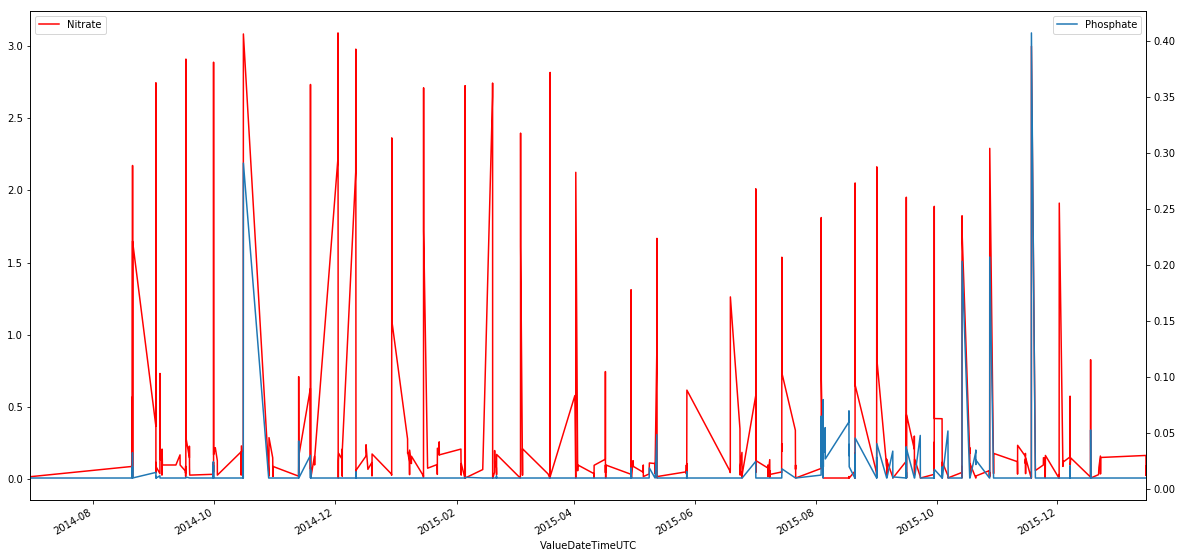

In [34]:
f, ax = plt.subplots(1, figsize=(20, 10))

df1.plot(ax=ax, 
         y='DataValue', 
         x='ValueDateTimeUTC', 
         label='Nitrate', 
         color='Red')
ax.legend(loc='upper left')

ax1 = ax.twinx()
df2.plot(ax=ax1, y='DataValue', x='ValueDateTimeUTC', label='Phosphate')
ax1.legend(loc='upper right')

---
## 5. See the people involved in Data collection of  `Nitrate`

In [35]:
actions = [r['FeatureAction']['Action'] for r in results]

In [36]:
orgs = []
for act in actions:
    if act['Method']['Organization']['OrganizationCode'] not in orgs:
        orgs.append(act['Method']['Organization']['OrganizationCode'])

In [37]:
orgs

['USUABL']

In [38]:
# Get people in organization
people = odm2rest_request('affiliations', {'organizationCode': ','.join(orgs)})

In [39]:
people_rec = []
for person in people:
    contact = 'No'
    if person['IsPrimaryOrganizationContact']:
        contact = 'Yes'
    people_rec.append({
            'FirstName': person['Person']['PersonFirstName'],
            'LastName': person['Person']['PersonLastName'],
            'Email': person['PrimaryEmail'],
            'StartDate': person['AffiliationStartDate'],
            'Organization': person['Organization']['OrganizationName'],
            'PrimaryContact': contact
        })

In [40]:
people_df = pd.DataFrame.from_records(people_rec)

In [41]:
people_df

,Email,FirstName,LastName,Organization,PrimaryContact,StartDate
0,dane.brophy@usu.edu,Dane,Brophy,USU Aquatic Biogeochemistry Lab,No,2015-01-01
1,benjamin.rider@usu.edu,Ben,Rider,USU Aquatic Biogeochemistry Lab,No,2015-01-01
2,michelle.baker@usu.edu,Michelle,Baker,USU Aquatic Biogeochemistry Lab,No,2015-01-01
3,unknown,Lisa,Ward,USU Aquatic Biogeochemistry Lab,No,2015-01-01
4,unknown,Elizabeth,Capps,USU Aquatic Biogeochemistry Lab,No,2015-01-01


---
## 6. Explore Datasets

In [42]:
ds = odm2rest_request('datasets')

In [43]:
dsdf = pd.DataFrame.from_records(ds)

In [44]:
print('There are {} datasets'.format(len(dsdf)))

There are 610 datasets


In [45]:
dsdf.head()

,DataSetAbstract,DataSetCode,DataSetID,DataSetTitle,DataSetTypeCV,DataSetUUID
0,Dataset consisting of observations of TN at RB...,RB_1300E_TN,1,Observations of TN at RB_1300E,Specimen time series,b35965e6-4125-e711-a8b2-0050569b0c9e
1,Dataset consisting of observations of TP at RB...,RB_1300E_TP,2,Observations of TP at RB_1300E,Specimen time series,b45965e6-4125-e711-a8b2-0050569b0c9e
2,Dataset consisting of observations of Nitrate ...,RB_1300E_Nitrate,3,Observations of Nitrate at RB_1300E,Specimen time series,b55965e6-4125-e711-a8b2-0050569b0c9e
3,Dataset consisting of observations of Ammonia ...,RB_1300E_Ammonia,4,Observations of Ammonia at RB_1300E,Specimen time series,b65965e6-4125-e711-a8b2-0050569b0c9e
4,Dataset consisting of observations of Phosphat...,RB_1300E_Phosphate,5,Observations of Phosphate at RB_1300E,Specimen time series,b75965e6-4125-e711-a8b2-0050569b0c9e


### Look at one site: PR_SpringCreekStateRoad113 

In [46]:
siteCode = 'PR_SpringCreekStateRoad113'
site = sites[sites['SamplingFeatureCode'] == siteCode]

In [47]:
site_dct = site.iloc[0].to_dict()

In [48]:
site_dct

{'ElevationDatumCV': 'EGM96',
 'Elevation_m': 1680.0,
 'FeatureGeometryWKT': None,
 'Latitude': 40.506788999999998,
 'Longitude': -111.44145,
 'SamplingFeatureCode': 'PR_SpringCreekStateRoad113',
 'SamplingFeatureDescription': None,
 'SamplingFeatureGeotypeCV': 'Point',
 'SamplingFeatureID': 64,
 'SamplingFeatureName': 'Spring Creek at State Road 113 in Midway, Utah',
 'SamplingFeatureTypeCV': 'Site',
 'SamplingFeatureUUID': 'f9470ed0-51fc-48f8-af66-5bc9f69c85a7',
 'SiteTypeCV': 'Stream',
 'SpatialReferenceID': 4,
 'geometry': <shapely.geometry.point.Point at 0x1165d7320>}

In [49]:
smap = folium.Map(location=[site_dct['Latitude'], site_dct['Longitude']], tiles='CartoDB positron', zoom_start=16)

In [50]:
folium.Marker(location=[site_dct['Latitude'], site_dct['Longitude']]).add_to(smap)

In [51]:
smap

In [52]:
siteds = dsdf[(dsdf['DataSetCode'].str.contains(siteCode))]

In [53]:
siteds

,DataSetAbstract,DataSetCode,DataSetID,DataSetTitle,DataSetTypeCV,DataSetUUID
576,Dataset consisting of observations of TN at PR...,PR_SpringCreekStateRoad113_TN,577,Observations of TN at PR_SpringCreekStateRoad113,Specimen time series,f35b65e6-4125-e711-a8b2-0050569b0c9e
577,Dataset consisting of observations of TP at PR...,PR_SpringCreekStateRoad113_TP,578,Observations of TP at PR_SpringCreekStateRoad113,Specimen time series,f45b65e6-4125-e711-a8b2-0050569b0c9e
578,Dataset consisting of observations of Tcolifor...,PR_SpringCreekStateRoad113_Tcoliform,579,Observations of Tcoliform at PR_SpringCreekSta...,Specimen time series,f55b65e6-4125-e711-a8b2-0050569b0c9e
579,Dataset consisting of observations of E-coli a...,PR_SpringCreekStateRoad113_E-coli,580,Observations of E-coli at PR_SpringCreekStateR...,Specimen time series,f65b65e6-4125-e711-a8b2-0050569b0c9e
580,Dataset consisting of observations of D18O at ...,PR_SpringCreekStateRoad113_D18O,581,Observations of D18O at PR_SpringCreekStateRoa...,Specimen time series,f75b65e6-4125-e711-a8b2-0050569b0c9e
581,Dataset consisting of observations of D2H at P...,PR_SpringCreekStateRoad113_D2H,582,Observations of D2H at PR_SpringCreekStateRoad113,Specimen time series,f85b65e6-4125-e711-a8b2-0050569b0c9e
582,Dataset consisting of observations of WaterTem...,PR_SpringCreekStateRoad113_WaterTemp,583,Observations of WaterTemp at PR_SpringCreekSta...,Specimen time series,f95b65e6-4125-e711-a8b2-0050569b0c9e


In [54]:
# Total Nitrogen data at this site
varcode = 'TN'
siteds_dct = siteds[siteds['DataSetCode'].str.contains(varcode)].reset_index().iloc[0].to_dict()
siteds_dct

{'DataSetAbstract': 'Dataset consisting of observations of TN at PR_SpringCreekStateRoad113 collected by multiple sampling efforts from 2013-2016 grouped by site and variable to generate unique datasets for visualization.',
 'DataSetCode': 'PR_SpringCreekStateRoad113_TN',
 'DataSetID': 577,
 'DataSetTitle': 'Observations of TN at PR_SpringCreekStateRoad113',
 'DataSetTypeCV': 'Specimen time series',
 'DataSetUUID': 'f35b65e6-4125-e711-a8b2-0050569b0c9e',
 'index': 576}

In [55]:
site_vals = odm2rest_request('datasetvalues', {'datasetUUID': siteds_dct['DataSetUUID']})

In [56]:
site_valsdf = pd.DataFrame.from_records(site_vals)

In [57]:
site_valsdf['valuedatetime'] = site_valsdf.apply(lambda x: pd.to_datetime(x['valuedatetime']).tz_localize(dateutil.tz.tzoffset(None, 
                                                                                                                               int(x['valuedatetimeutcoffset'])*60*60)).astimezone(pytz.UTC), axis=1)

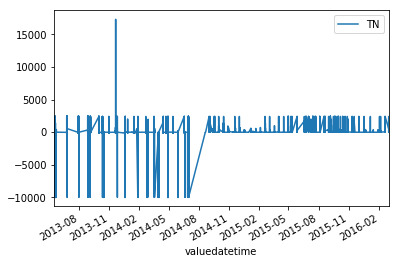

In [58]:
site_valsdf.plot(y='datavalue', x='valuedatetime', label=varcode)